In [1]:
import cv2
import numpy as np
import pickle
import os
import itertools
import tqdm
import random
from PIL import Image

import sys; sys.path.insert(0, "intermediate_fusion")
from text_preprocessing import Tokenizer, pad_sequences
from gensim.models import KeyedVectors
from gensim.utils import tokenize, simple_preprocess

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import models

import matplotlib.pyplot as plt

/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
BASE_DIR = "dataset/"
DATASET_DIR = BASE_DIR + "text_data/"
IMAGES_DIR = BASE_DIR + "images/all_items/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 32

In [3]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return np.moveaxis(img, 2, 0)

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [4]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
item_to_rooms_map = {item_url.split("/")[-1].split(".jpg")[0] : val for item_url, val in item_to_rooms_map.items()}
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)
    
with open(BASE_DIR + "train_sets_reweighted.pkl", "rb") as file:
    train_sets = pickle.load(file)
with open(BASE_DIR + "val_data_reweighted.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
with open(BASE_DIR + "preprocessed_text.pkl", "rb") as file:
    item_to_info = pickle.load(file)

890.333.75 does not exist
991.333.98 does not exist
990.612.97 does not exist


In [184]:
# emb_dir = "intermediate_fusion_reweighted"
# all_embeddings = [pickle.load(open(os.path.join(emb_dir, fname), "rb"))
#                   for fname in os.listdir(emb_dir) if fname.endswith('.p') and fname.startswith('embeddings')]
all_embeddings = [list(zip(*pickle.load(open("vae/multimodal_vae_embeddings.pickle", "rb"))))]
all_embeddings[0][1] = np.stack(all_embeddings[0][1], axis=0)
all_embeddings.append(pickle.load(open("intermediate_fusion_embeddings/embeddings_0.p", "rb")))
all_embeddings.append(pickle.load(open("intermediate_fusion_controls/embeddings_text_only.p", "rb")))
all_embeddings.append(pickle.load(open("naive_clip/untuned_CLIP_embeddings.pkl", "rb")))

image_ids = sorted(set.intersection(*(set(x[0]) for x in all_embeddings)))
embs = [emb[[ids.index(id) for id in image_ids]] for ids, emb in all_embeddings]

In [182]:
import emblaze

In [185]:
embeddings = emblaze.EmbeddingSet([
    emblaze.Embedding({
        emblaze.Field.POSITION: emb,
        emblaze.Field.COLOR: np.zeros(len(emb))
    }, label=label, metric='cosine') for emb, label in zip(embs,
                                          ['VAE', 'IF', 'Text', 'CLIP'])
])
embeddings

Embeddings are not 2D, skipping alignment


<EmbeddingSet with 4 embeddings:
	<Embedding with 1629 items, 2 fields (position, color)>
	<Embedding with 1629 items, 2 fields (position, color)>
	<Embedding with 1629 items, 2 fields (position, color)>
	<Embedding with 1629 items, 2 fields (position, color)>>

In [186]:
embeddings.compute_neighbors(n_neighbors=100)

In [187]:
reduced = embeddings.project(method=emblaze.ProjectionTechnique.ALIGNED_UMAP)
reduced

/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


<EmbeddingSet with 4 embeddings:
	<Embedding with 1629 items, 3 fields (position, color, highlight)>
	<Embedding with 1629 items, 3 fields (position, color, highlight)>
	<Embedding with 1629 items, 3 fields (position, color, highlight)>
	<Embedding with 1629 items, 3 fields (position, color, highlight)>>

In [188]:
images = [np.array(Image.open("dataset/images/all_items/" + id + ".jpg").resize((224, 224)))
          for id in image_ids]
img_thumbnails = emblaze.ImageThumbnails(images)
text_thumbnails = emblaze.TextThumbnails([item_categories[id] for id in image_ids])
thumbnails = emblaze.CombinedThumbnails([img_thumbnails, text_thumbnails])

In [189]:
from collections import Counter
labels = [item_categories[id].split()[-1].lower() for id in image_ids]
cutoff = 28
label_counts = Counter(labels)
print(len([l for l in label_counts if label_counts[l] > cutoff]))
labels = [l if label_counts[l] > cutoff else "other" for l in labels]

12


In [215]:
for emb in reduced.embeddings:
    emb.set_field(emblaze.Field.COLOR, labels)

In [217]:
w = emblaze.Viewer(embeddings=reduced, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 1629, 'ids'…

In [31]:
w.visibleSidebarPane = 3

# Ranking Evaluations

In [5]:
with open("dataset/val_data_reweighted.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
    
val_products = set([x for pair in val_pairs for x in pair])
# val_id_indexes = [i for i, id in enumerate(image_ids) if id in val_products]
val_image_ids = sorted(val_products)
# val_image_ids = [image_ids[i] for i in val_id_indexes]
# val_embeddings = [emb[val_id_indexes] for emb in embs]

In [6]:
emb_image_ids, embs = zip(*pickle.load(open("vae/multimodal_vae_embeddings.pickle", "rb")))
val_embeddings = [np.stack([embs[emb_image_ids.index(id)] for id in val_image_ids], axis=0)]
val_embeddings[0].shape

(680, 256)

In [73]:
import math
class Evaluator:
    def __init__(self, GroundTruth):
      self.GroundTruth = GroundTruth

    def NDCG_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      DCGScore = 0
      result = []
      for i, item in enumerate(sortedRankResult[:topk]):
        if item[0] in self.GroundTruth:
          result.append((item, i))
      DCGScore = sum([item[0][1]/math.log(item[1]+2, 2) for item in result])
      IDCGScore = sum([1/math.log(i+2,2) for i in range(topk)])
      NDCG = DCGScore / IDCGScore

      return NDCG
    
    def Score_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      return sum(i[1] for i in sortedRankResult[:topk] if i[0] in self.GroundTruth) / topk
    
    def Precision(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(topkresult)

    def Recall(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(self.GroundTruth)
    
    def FValue(self, rankresult, topk):
      precision = self.Precision(rankresult, topk)
      recall = self.Recall(rankresult, topk)
      return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

NDCG: 0.0085 (95% CI -0.074-0.091)
Score: 0.0091 (95% CI -0.073-0.091)
Precision: 0.0091 (95% CI -0.073-0.091)
Recall: 0.0018 (95% CI -0.017-0.021)
FValue: 0.0028 (95% CI -0.026-0.032)



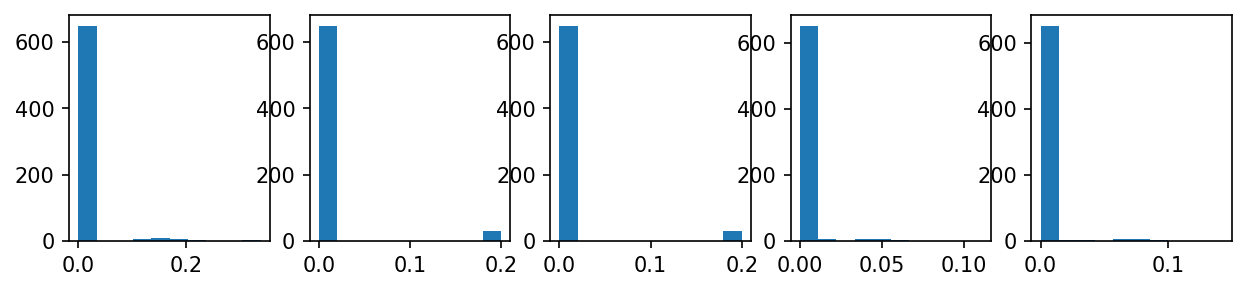

In [88]:
# Now try ranking all pairs
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

all_similarities = [1 / (1 + np.exp(-np.dot(emb, emb.T))) for emb in val_embeddings]
all_similarities =  [np.mean(np.stack(all_similarities), axis=0)]
for sims in all_similarities:
    TOP_K = 5

    ndcg = np.zeros(len(val_products))
    score = np.zeros(len(val_products))
    precision = np.zeros(len(val_products))
    recall = np.zeros(len(val_products))
    fvalue = np.zeros(len(val_products))
    for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, sims)):
        evaluator = Evaluator(ground_truth)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != val_image_ids[i]}
        ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
        score[i] = evaluator.Score_Eval(rankings, TOP_K)
        precision[i] = evaluator.Precision(rankings, TOP_K)
        recall[i] = evaluator.Recall(rankings, TOP_K)
        fvalue[i] = evaluator.FValue(rankings, TOP_K)
    print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
    print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
    print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
    print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
    print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
    print("")
    plt.figure(figsize=(10, 2), dpi=150)
    plt.subplot(151)
    plt.hist(ndcg)
    plt.subplot(152)
    plt.hist(score)
    plt.subplot(153)
    plt.hist(precision)
    plt.subplot(154)
    plt.hist(recall)
    plt.subplot(155)
    plt.hist(fvalue)
    plt.show()

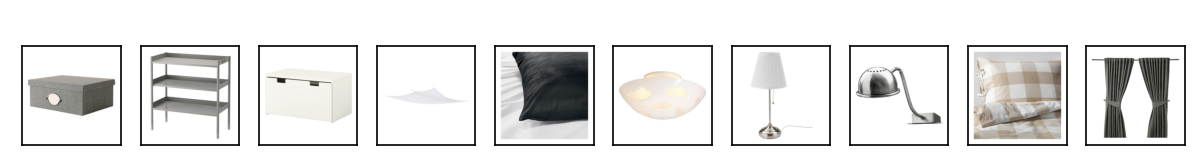

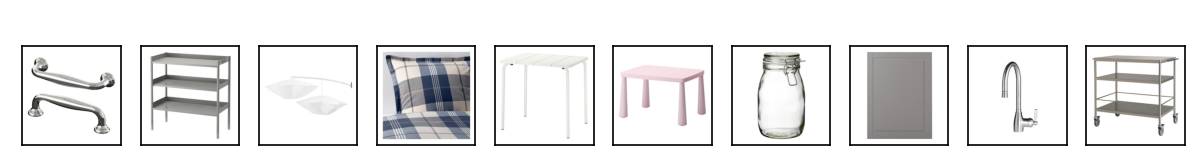

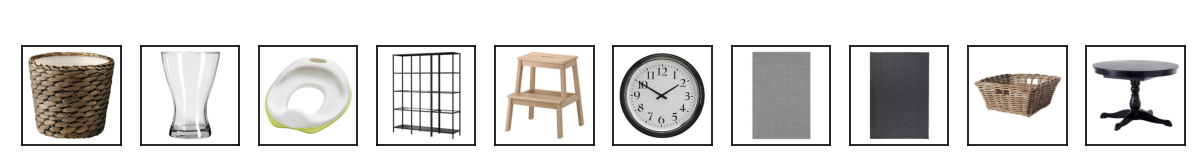

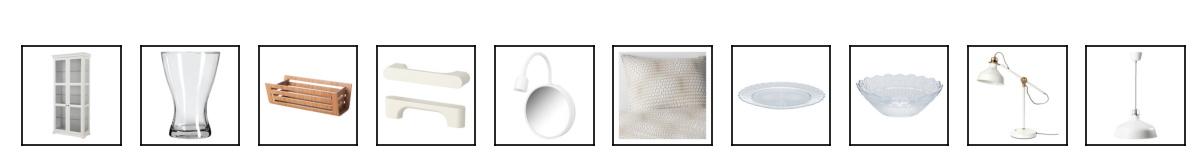

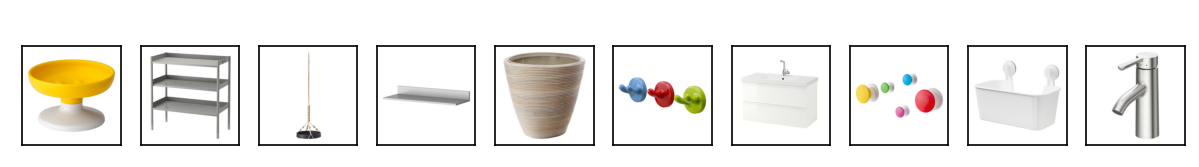

In [83]:
# Let's look at some examples
example_idxs = np.random.choice([i for i in range(len(val_image_ids)) if ndcg[i] > 0.1], size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 10, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[idx] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    best_idxs = np.argsort(all_similarities[0][idx])[-5:]
    for i, match_idx in enumerate(reversed(best_idxs)):
        plt.subplot(1, 10, i + 2)
        plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[match_idx] + ".jpg").resize((224, 224)))
        plt.title('yes' if val_image_ids[match_idx] in ground_truth_lists[idx] else 'no', color='white')
        plt.xticks([])
        plt.yticks([])
    gt = list(ground_truth_lists[idx])
    true_idxs = np.random.choice(len(gt), size=4, replace=False)
    for i, match_idx in enumerate(true_idxs):
        plt.subplot(1, 10, i + 7)
        plt.imshow(Image.open("dataset/images/all_items/" + gt[match_idx] + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

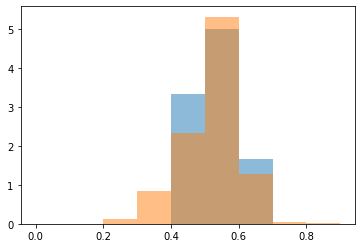

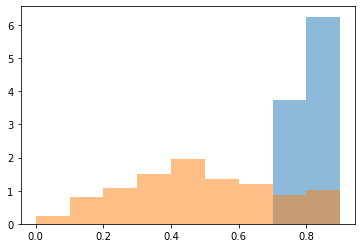

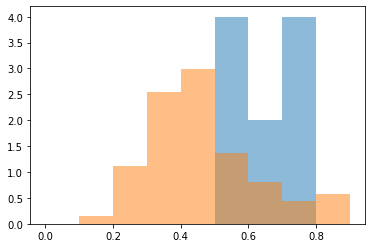

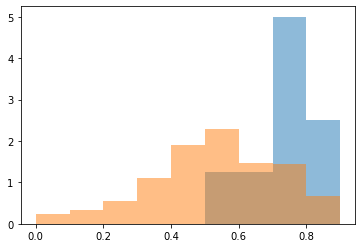

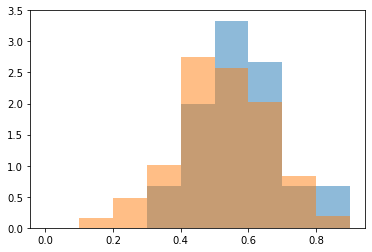

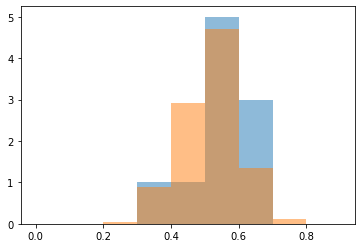

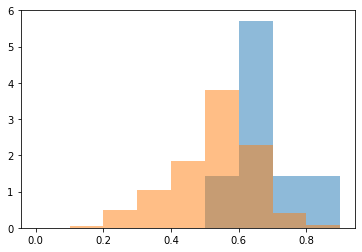

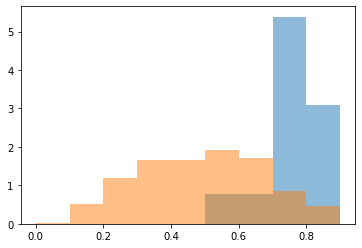

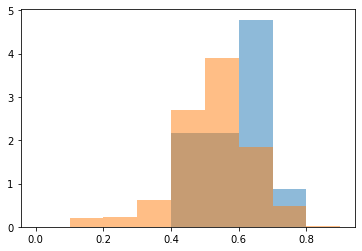

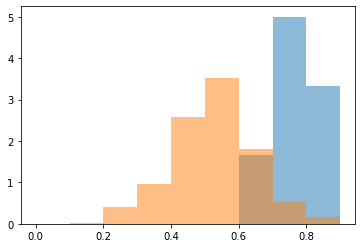

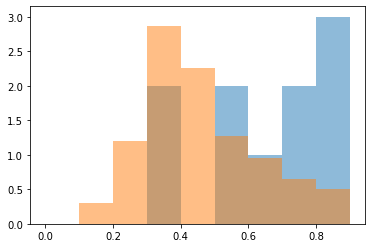

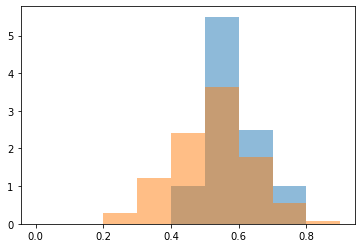

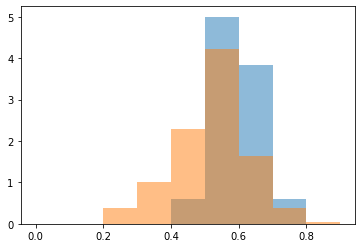

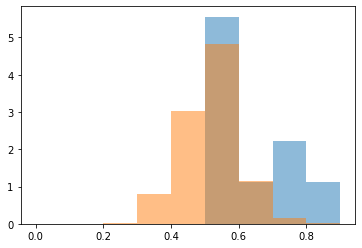

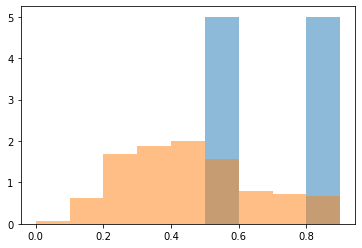

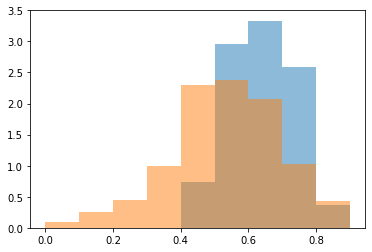

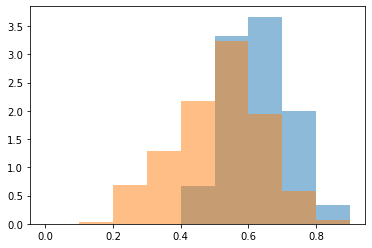

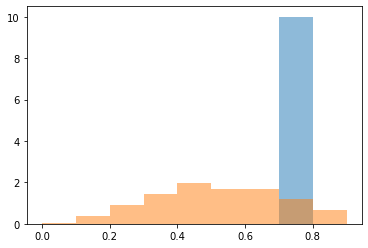

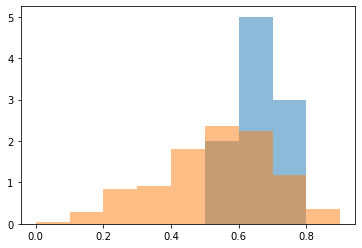

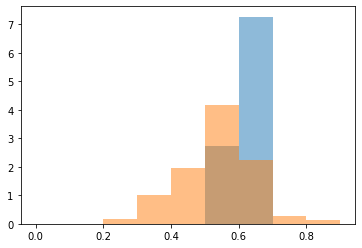

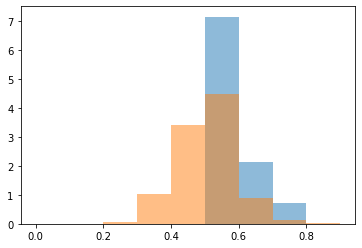

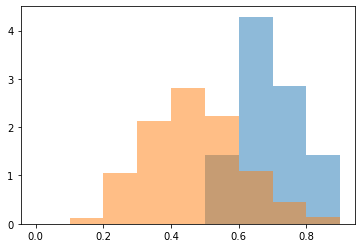

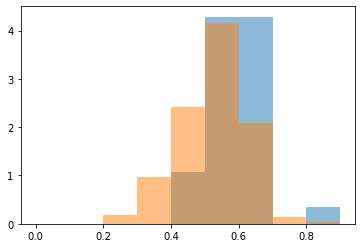

0.6512652 0.50540525 15.005502063273727 1437.9944979367262


In [81]:
# Let's see if the rankings elevate positive objects more than negative objects
pos_sims = []
pos_counts = []
neg_sims = []
neg_counts = []
for query_idx, query_id in enumerate(val_image_ids):
    sim_row = all_similarities[0][query_idx]
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != query_id}
    pos = [r for id, r in rankings.items() if id in ground_truth_lists[query_idx]]
    neg = [r for id, r in rankings.items() if id not in ground_truth_lists[query_idx]]
    pos_sims.append(np.mean(pos))
    pos_counts.append(len(pos))
    neg_sims.append(np.mean(neg))
    neg_counts.append(len(neg))
    if np.random.uniform() < 0.01:
        plt.figure()
        plt.hist(pos, alpha=0.5, bins=np.arange(0, 1, 0.1), density=True)
        plt.hist(neg, alpha=0.5, bins=np.arange(0, 1, 0.1), density=True)
        plt.show()
print(np.mean(pos_sims), np.mean(neg_sims), np.mean(pos_counts), np.mean(neg_counts))

## Triplet ranking problem - given two objects, find a most compatible third one

Text(0.5, 1.0, '6245')

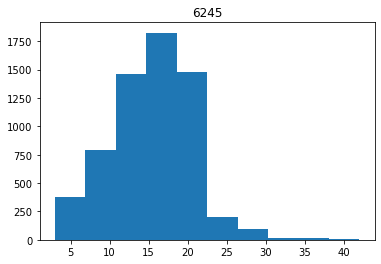

In [84]:
triplet_pairs = []
triplet_ground_truths = []
for pair in (val_pairs[i] for i in np.argwhere(y_val).flatten()):
    triplet_pairs.append(pair)
    gt = set()
    for room_url in item_to_rooms_map[pair[0]]:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        if pair[1] in room_to_items[room_id]:
            gt |= set(room_to_items[room_id])
    triplet_ground_truths.append(gt)

plt.hist([len(x) for x in triplet_ground_truths])
plt.title(len(triplet_pairs))

NDCG: 0.0038 (95% CI -0.048-0.056)
Score: 0.0044 (95% CI -0.053-0.062)
Precision: 0.0044 (95% CI -0.053-0.062)
Recall: 0.0016 (95% CI -0.023-0.026)
FValue: 0.0023 (95% CI -0.029-0.034)



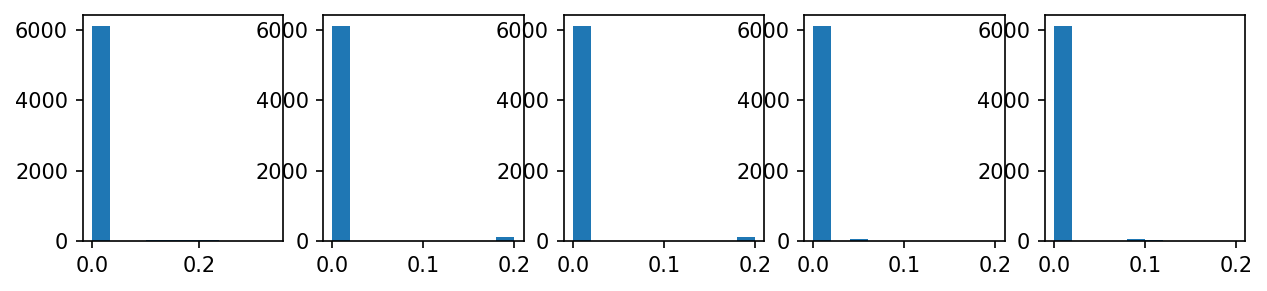

In [89]:
all_similarities = [1 / (1 + np.exp(-np.dot(emb, emb.T))) for emb in val_embeddings]
all_similarities = [np.mean(np.stack(all_similarities), axis=0)]

val_image_index = {id: i for i, id in enumerate(val_image_ids)}

for sims in all_similarities:
    TOP_K = 5

    ndcg = np.zeros(len(triplet_pairs))
    score = np.zeros(len(triplet_pairs))
    precision = np.zeros(len(triplet_pairs))
    recall = np.zeros(len(triplet_pairs))
    fvalue = np.zeros(len(triplet_pairs))

    for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
        sim_row = np.amin(np.vstack([sims[val_image_index[pair[0]]],
                                     sims[val_image_index[pair[1]]]]), axis=0)
        
        evaluator = Evaluator(ground_truth)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product not in pair}
        ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
        score[i] = evaluator.Score_Eval(rankings, TOP_K)
        precision[i] = evaluator.Precision(rankings, TOP_K)
        recall[i] = evaluator.Recall(rankings, TOP_K)
        fvalue[i] = evaluator.FValue(rankings, TOP_K)
        
    print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
    print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
    print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
    print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
    print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
    print("")
    plt.figure(figsize=(10, 2), dpi=150)
    plt.subplot(151)
    plt.hist(ndcg)
    plt.subplot(152)
    plt.hist(score)
    plt.subplot(153)
    plt.hist(precision)
    plt.subplot(154)
    plt.hist(recall)
    plt.subplot(155)
    plt.hist(fvalue)
    plt.show()

## Category-Limited Approach

In [164]:
item_property[val_image_ids[100]]

{'name': 'NYM',
 'type': 'Lamp shade',
 'color': 'Black,copper-colour',
 'size': '19 cm',
 'img': 'images/objects/102.814.10.jpg',
 'desc': 'View more product information Create your own personalised pendant or table lamp by combining the lamp shade with your choice of cord set or base.'}

In [8]:
preprocessed_categories = [set(simple_preprocess(item_categories[o])) for o in val_image_ids]
def eligible_product_indexes(product_idx, cutoff=0.5):
    cat = preprocessed_categories[product_idx]
    cat_sims = [len(x & cat) / max(1, len(x | cat)) for x in preprocessed_categories]
    return [i for i, sim in enumerate(cat_sims) if sim > cutoff]

query_products = {val_image_ids[i]: [val_image_ids[j] for j in eligible_product_indexes(i)]
                  for i in range(len(val_image_ids)) if len(eligible_product_indexes(i)) > 10}
print(len(query_products))
query, candidates = list(query_products.items())[np.random.randint(0, len(query_products))]
print(item_categories[query])
print(', '.join([item_categories[cand] for cand in candidates]))

97
Wardrobe
Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe, Wardrobe


In [90]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

sims = all_similarities[0]
TOP_K = 5

scores = []
ground_truth_objects = []
score_query_idxs = []

for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, sims)):
    for gt_item in ground_truth:
        if gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product != val_image_ids[i] and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print(len(scores), np.mean(scores))

670 0.382089552238806


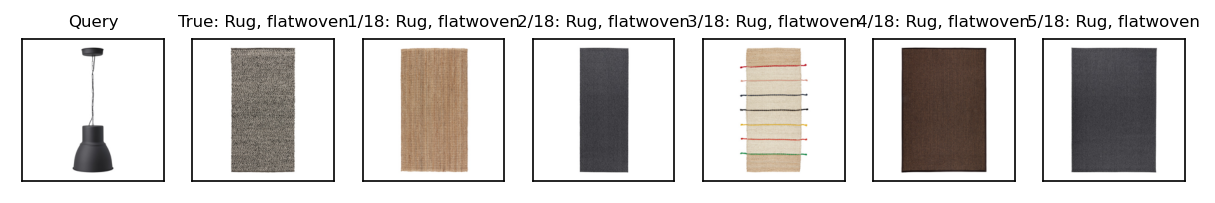

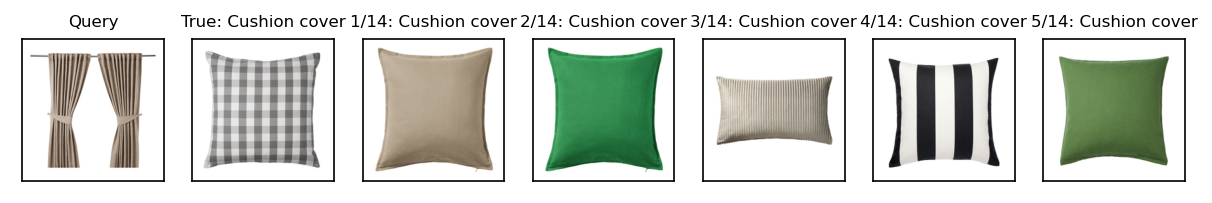

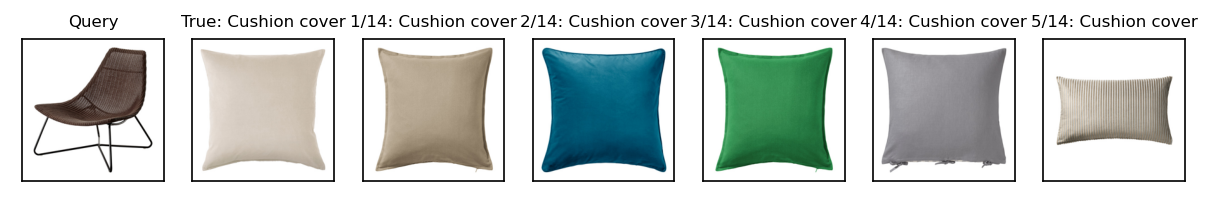

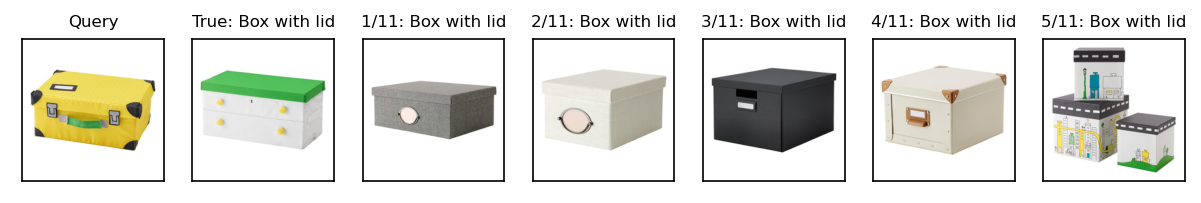

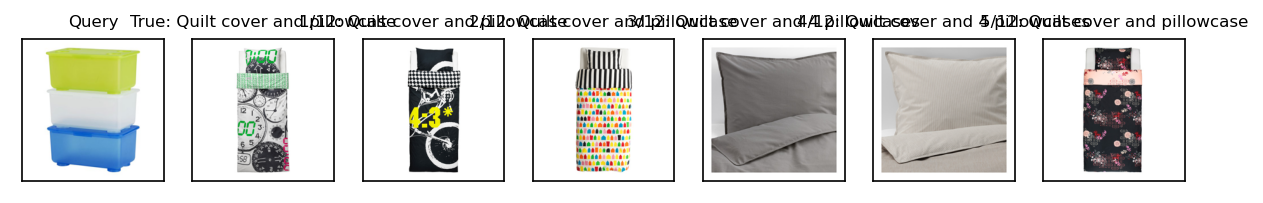

In [91]:
# Let's look at some examples
example_idxs = np.random.choice([i for i in range(len(scores)) if scores[i] < 0.5], size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 7, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[score_query_idxs[idx]] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    gt_item = ground_truth_objects[idx]
    plt.title("Query", fontsize=8)

    plt.subplot(1, 7, 2)
    plt.imshow(Image.open("dataset/images/all_items/" + gt_item + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("True: " + item_categories[gt_item], fontsize=8)

    rankings = {product: output for product, output in zip(val_image_ids, all_similarities[0][score_query_idxs[idx]])
                if product != val_image_ids[score_query_idxs[idx]] and product in query_products[gt_item]}
    best_idxs = sorted(rankings, key=rankings.get, reverse=True)[:5]
    for i, match_idx in enumerate(best_idxs):
        plt.subplot(1, 7, i + 3)
        plt.imshow(Image.open("dataset/images/all_items/" + match_idx + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
        plt.title("{}/{}: ".format(i + 1, len(rankings)) + item_categories[match_idx], fontsize=8)
    plt.show()

In [93]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

TOP_K = 5

scores = []
ground_truth_objects = []
score_query_idxs = []
print(sims.shape, len(ground_truth_lists))
for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
    sim_row = np.amin(np.vstack([sims[val_image_index[pair[0]]],
                                 sims[val_image_index[pair[1]]]]), axis=0)

    for gt_item in ground_truth:
        if gt_item in pair or gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product not in pair and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print(len(scores), np.mean(scores))

(680, 680) 680
3338 0.3936488915518274


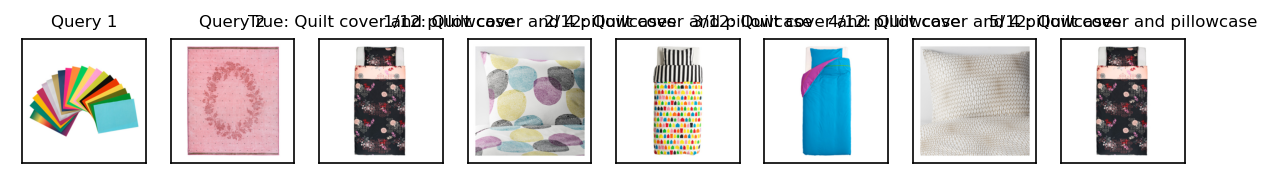

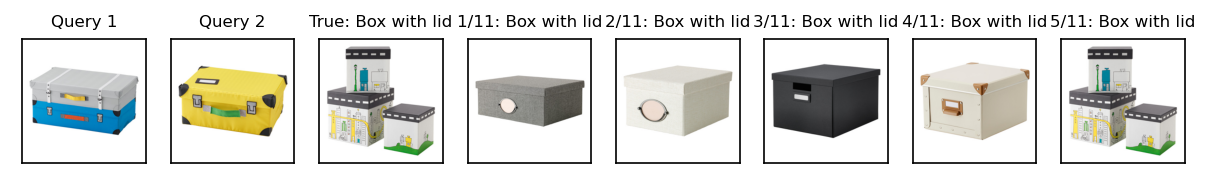

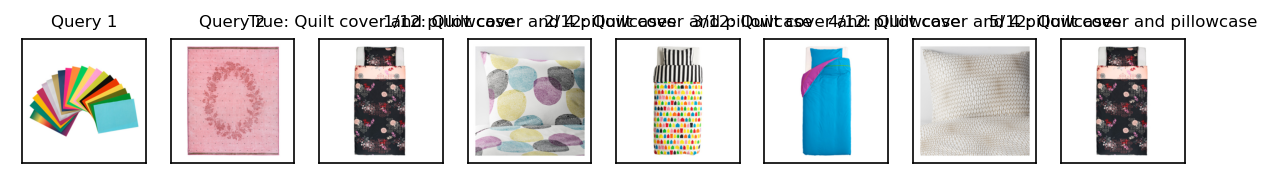

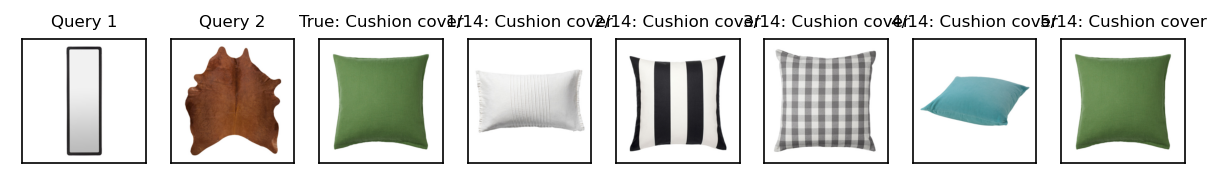

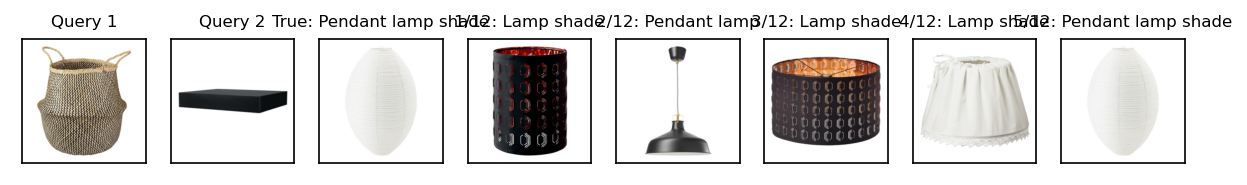

In [96]:
# Let's look at some examples
example_idxs = np.random.choice([i for i in range(len(scores)) if scores[i] > 0.5], size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 8, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + triplet_pairs[score_query_idxs[idx]][0] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("Query 1", fontsize=8)

    plt.subplot(1, 8, 2)
    plt.imshow(Image.open("dataset/images/all_items/" + triplet_pairs[score_query_idxs[idx]][1] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("Query 2", fontsize=8)

    gt_item = ground_truth_objects[idx]

    plt.subplot(1, 8, 3)
    plt.imshow(Image.open("dataset/images/all_items/" + gt_item + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("True: " + item_categories[gt_item], fontsize=8)

    pair = triplet_pairs[score_query_idxs[idx]]
    sim_row = np.amin(np.vstack([sims[val_image_index[pair[0]]],
                                 sims[val_image_index[pair[1]]]]), axis=0)
    
    rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                if product not in triplet_pairs[score_query_idxs[idx]] and product in query_products[gt_item]}
    best_idxs = sorted(rankings, key=rankings.get, reverse=True)[:5]
    for i, match_idx in enumerate(best_idxs):
        plt.subplot(1, 8, i + 4)
        plt.imshow(Image.open("dataset/images/all_items/" + match_idx + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
        plt.title("{}/{}: ".format(i + 1, len(rankings)) + item_categories[match_idx], fontsize=8)
    plt.show()

# With Endpoint Classifier

In [102]:
VGG_RELU_LAYERS = [3, 8, 15, 22, 29]
VGG_RELU_LAYER_SIZES = [64, 128, 256, 512, 512]

with open("intermediate_fusion/text_preprocessing_info_reweighted.pkl", "rb") as file:
    WORD_INDEX, WORD2VEC_EMBEDDING_MATRIX = pickle.load(file)

In [103]:
class OutputClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OutputClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, first_embs, second_embs):
        output = torch.cat([first_embs, second_embs], 1) # (emb_1 * emb_2).sum(1)
        output = self.fc1(output)
        output = self.dropout1(output)
        output = F.relu(output)
        output = self.fc2(output)
        return output

In [190]:
all_embs = []
emb_product_ids = None
emb_paths = ["intermediate_fusion_reweighted/embeddings_0.p",
            "intermediate_fusion_reweighted/embeddings_1.p",
            "intermediate_fusion_reweighted/embeddings_2.p"]
checkpoint_paths = ["intermediate_fusion_reweighted/base_0_checkpoint_classifier.p",
                   "intermediate_fusion_reweighted/base_1_checkpoint_classifier.p",
                   "intermediate_fusion_reweighted/base_2_checkpoint_classifier.p"]
# # emb_paths = ["intermediate_fusion_reweighted/text_only_embeddings.p"]
# # checkpoint_paths = ["intermediate_fusion_reweighted/text_only_checkpoint_classifier.p"]

for path in emb_paths:
    with open(path, "rb") as file:
        new_product_ids, embs = pickle.load(file)
    if emb_product_ids is not None: assert new_product_ids == emb_product_ids
    else: emb_product_ids = new_product_ids
    all_embs.append(embs)

In [191]:
combs = list(itertools.product(range(len(val_image_ids)), range(len(val_image_ids))))
print(len(combs))

def make_batches(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        

462400


In [86]:
# embs = ... # matrix of embeddings for all products
# emb_product_ids = ... # list of IDs corresponding to each row in embs
# emb_product_idx_mapping = {id: i for i, id in enumerate(emb_product_ids)}
# model = ... # a classification model that takes two arguments: a batch of "first" embeddings and a batch of "second" embeddings

# val_image_ids = sorted([x for pair in val_pairs for x in pair])

# combs = list(itertools.product(range(len(val_image_ids)), range(len(val_image_ids))))
# print(len(combs))

# def make_batches(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]
        
# results_list = []
# with torch.no_grad():
#     for batch in tqdm.tqdm(make_batches(combs, 32), total=len(combs) // 32 + 1):
#         first_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[0]]]] for x in batch]))
#         second_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[1]]]] for x in batch]))
#         results_list.append(model(first_embs, second_embs).cpu().numpy())
# results = np.concatenate(results_list).reshape(len(val_image_ids), len(val_image_ids))
# results = 1 / (1 + np.exp(-results)) # optional sigmoid transformation (if not applied by model)

462400


In [192]:
all_predictions = []
emb_product_idx_mapping = {id: i for i, id in enumerate(emb_product_ids)}

for embs, path in zip(all_embs, checkpoint_paths):
    model = OutputClassifier(256, 1)

    state = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(state)

    sub_results = []
    with torch.no_grad():
        for batch in tqdm.tqdm(make_batches(combs, 32), total=len(combs) // 32 + 1):
            first_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[0]]]] for x in batch]))
            second_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[1]]]] for x in batch]))
            sub_results.append(model(first_embs, second_embs).cpu().numpy())
    sub_results = np.concatenate(sub_results).reshape(len(val_image_ids), len(val_image_ids))
    sub_results = 1 / (1 + np.exp(-sub_results))
    all_predictions.append(sub_results)

results = np.mean(np.stack(all_predictions, axis=0), axis=0)
results.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 14450/14451 [00:03<00:00, 3977.84it/s]


(680, 680)

In [15]:
# Alternative: load from a matrix of predictions
results = np.load("naive_clip/linear_layer_unreweighted_CLIP_predictions.npy")
results.shape

(680, 680)

In [194]:
# Now try ranking all pairs
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

TOP_K = 5

ndcg = np.zeros(len(val_products))
score = np.zeros(len(val_products))
precision = np.zeros(len(val_products))
recall = np.zeros(len(val_products))
fvalue = np.zeros(len(val_products))
for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, results)):
    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != val_image_ids[i]}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
print("")

NDCG: 0.0072 (95% CI -0.056-0.070)
Score: 0.0078 (95% CI -0.057-0.072)
Precision: 0.0109 (95% CI -0.078-0.100)
Recall: 0.0023 (95% CI -0.019-0.024)
FValue: 0.0037 (95% CI -0.029-0.037)



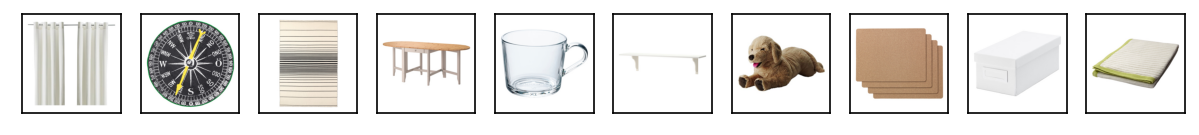

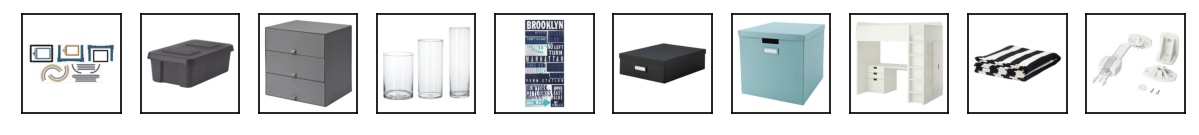

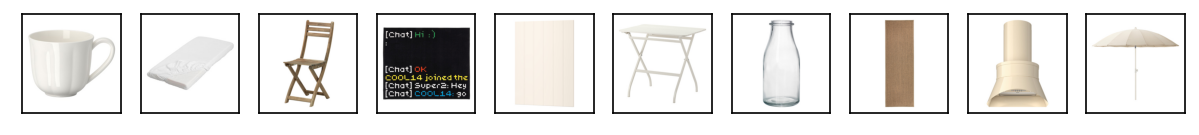

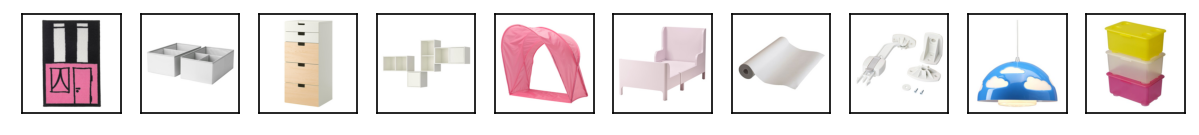

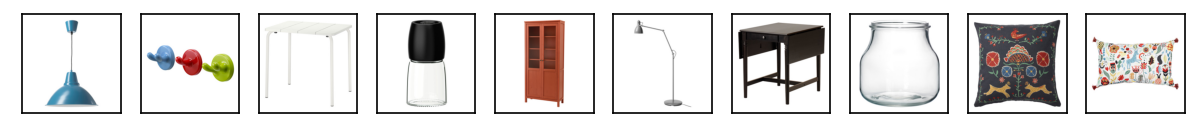

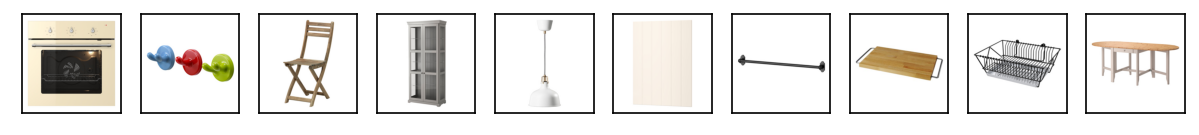

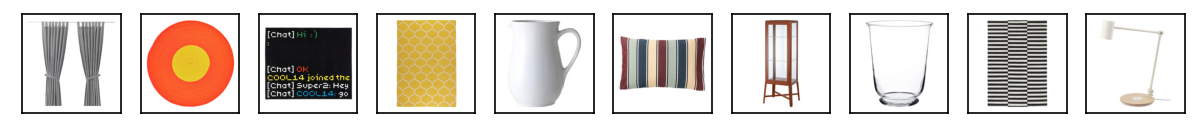

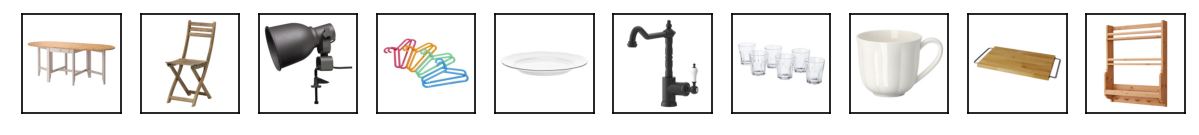

In [125]:
# Let's look at some examples
example_idxs = np.random.choice(len(val_image_ids), size=10, replace=False)
for idx in example_idxs:
    if len(ground_truth_lists[idx]) < 6: continue
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 10, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[idx] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    best_idxs = np.argsort(results[idx])[-3:]
    for i, match_idx in enumerate(reversed(best_idxs)):
        plt.subplot(1, 10, i + 2)
        plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[match_idx] + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
    gt = list(ground_truth_lists[idx])
    true_idxs = np.random.choice(len(gt), size=6, replace=False)
    for i, match_idx in enumerate(true_idxs):
        plt.subplot(1, 10, i + 5)
        plt.imshow(Image.open("dataset/images/all_items/" + gt[match_idx] + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

NDCG: 0.0044 (95% CI -0.046-0.054)
Score: 0.0047 (95% CI -0.045-0.055)
Precision: 0.0066 (95% CI -0.063-0.077)
Recall: 0.0021 (95% CI -0.022-0.026)
FValue: 0.0032 (95% CI -0.032-0.038)



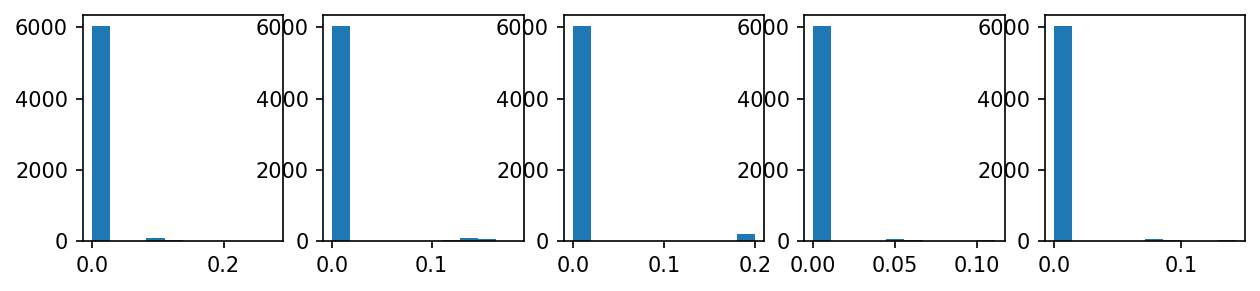

In [126]:
val_image_index = {id: i for i, id in enumerate(val_image_ids)}

TOP_K = 5

ndcg = np.zeros(len(triplet_pairs))
score = np.zeros(len(triplet_pairs))
precision = np.zeros(len(triplet_pairs))
recall = np.zeros(len(triplet_pairs))
fvalue = np.zeros(len(triplet_pairs))

for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
    sim_row = np.mean(np.vstack([results[val_image_index[pair[0]]],
                                 results[val_image_index[pair[1]]]]), axis=0)

    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product not in pair}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)

print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
print("")
plt.figure(figsize=(10, 2), dpi=150)
plt.subplot(151)
plt.hist(ndcg)
plt.subplot(152)
plt.hist(score)
plt.subplot(153)
plt.hist(precision)
plt.subplot(154)
plt.hist(recall)
plt.subplot(155)
plt.hist(fvalue)
plt.show()

In [198]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

TOP_K = 5

scores = []
ground_truth_objects = []
score_query_idxs = []
print(results.shape, len(ground_truth_lists))
for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, results)):
    for gt_item in ground_truth:
        if gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product != val_image_ids[i] and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print(len(scores), np.mean(scores))

(680, 680) 680
670 0.3656716417910448


Trunk for toys - A trunk for toys that looks like a suitcase  perfect for everything needed when its time to go on an adventure at home.


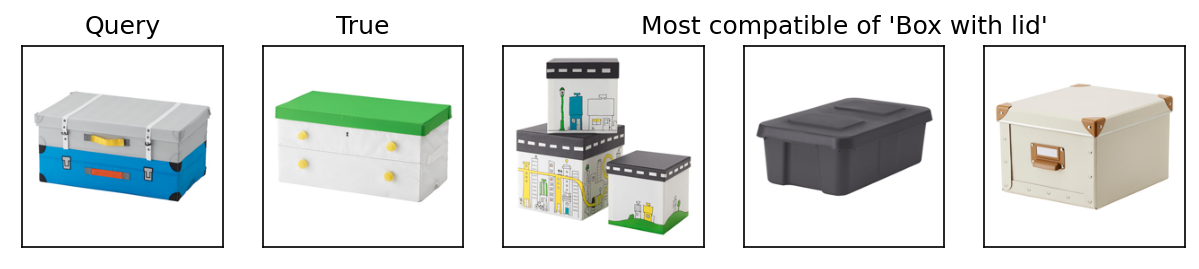

Rug, flatwoven - Handwoven by skilled craftspeople, each one is unique. Made in India in organised weaving centres with good working conditions and fair wages.


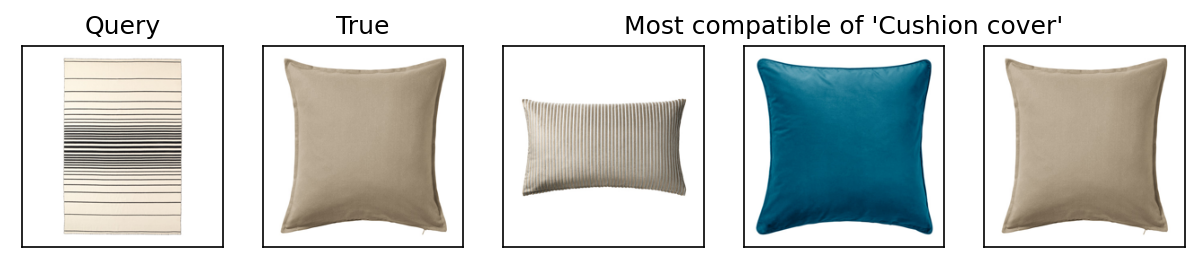

Side table - 


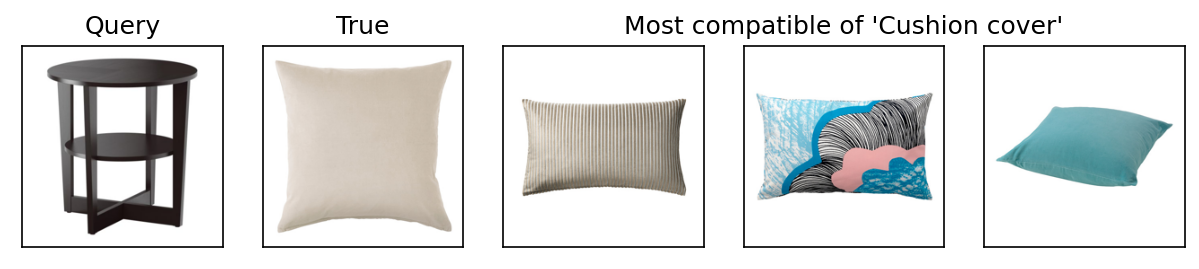

Magazine file - Easy to pull out and lift as the magazine file has a cut-out handle.


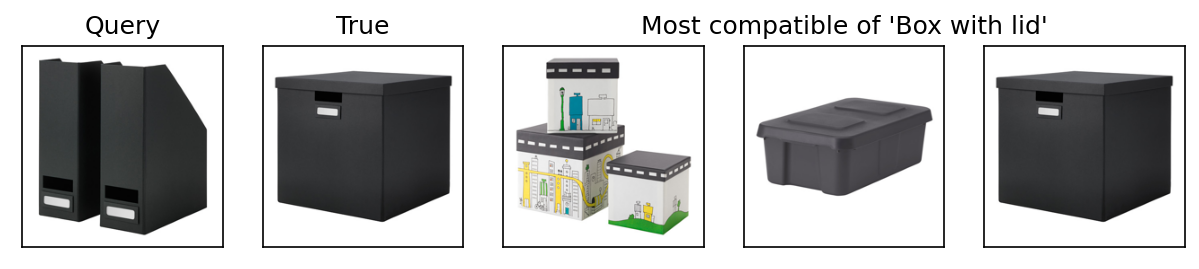

Plant pot - 


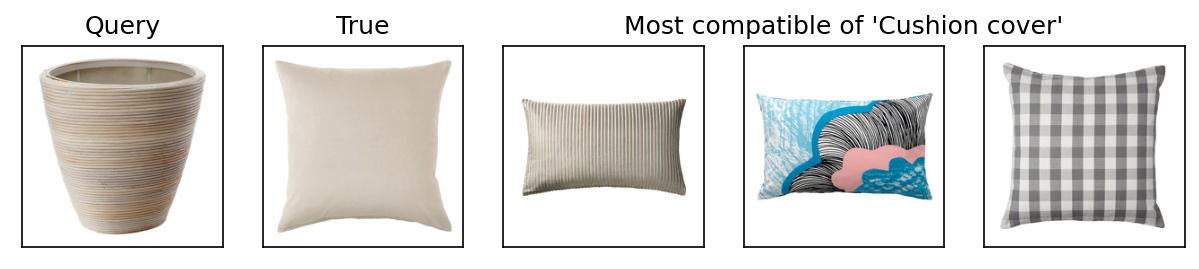

In [214]:
# Let's look at some examples
example_idxs = np.random.choice([i for i in range(len(scores)) if scores[i] > 0.5], size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 5, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[score_query_idxs[idx]] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    gt_item = ground_truth_objects[idx]
    plt.title("Query")
    print(item_categories[val_image_ids[score_query_idxs[idx]]], '-',
          item_to_description.get('/static/images/' + val_image_ids[score_query_idxs[idx]] + '.jpg', {}).get('desc', ''))

    plt.subplot(1, 5, 2)
    plt.imshow(Image.open("dataset/images/all_items/" + gt_item + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("True") # + item_categories[gt_item], fontsize=8)

    rankings = {product: output for product, output in zip(val_image_ids, results[score_query_idxs[idx]])
                if product != val_image_ids[score_query_idxs[idx]] and product in query_products[gt_item]}
    best_idxs = sorted(rankings, key=rankings.get, reverse=True)[:3]
    for i, match_idx in enumerate(best_idxs):
        plt.subplot(1, 5, i + 3)
        plt.imshow(Image.open("dataset/images/all_items/" + match_idx + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
        if i == 1: plt.title(f"Most compatible of '{item_categories[gt_item]}'")
        # plt.title("{}/{}: ".format(i + 1, len(rankings)) + item_categories[match_idx], fontsize=8)
    plt.show()

In [196]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

TOP_K = 5

scores = []
ground_truth_objects = []
score_query_idxs = []
print(results.shape, len(ground_truth_lists))
for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
    sim_row = np.amin(np.vstack([results[val_image_index[pair[0]]],
                                 results[val_image_index[pair[1]]]]), axis=0)

    for gt_item in ground_truth:
        if gt_item in pair or gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product not in pair and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print(len(scores), np.mean(scores))

(680, 680) 680
3338 0.3559017375674056


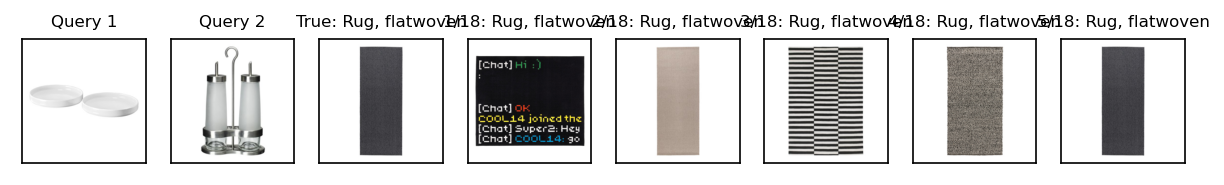

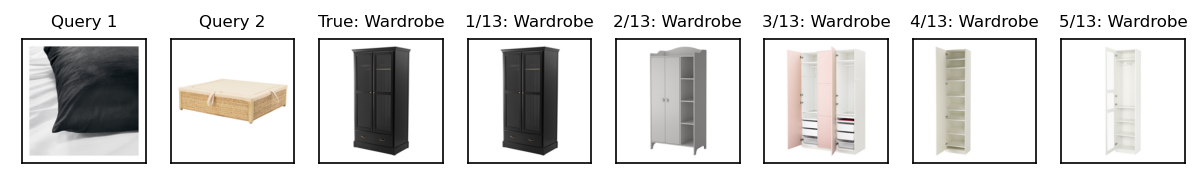

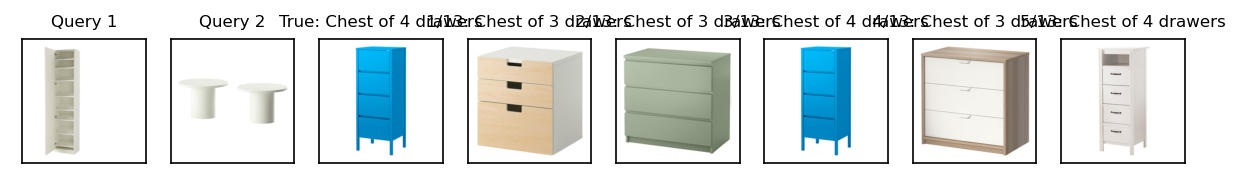

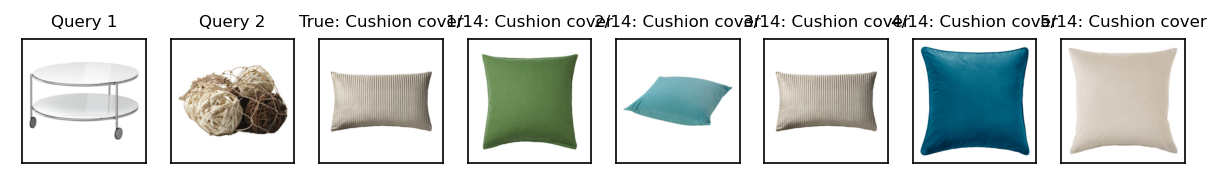

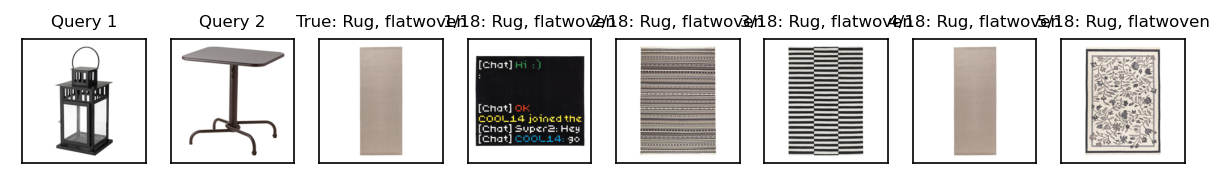

In [197]:
# Let's look at some examples
example_idxs = np.random.choice([i for i in range(len(scores)) if scores[i] > 0.5], size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3), dpi=150)
    plt.subplot(1, 8, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + triplet_pairs[score_query_idxs[idx]][0] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("Query 1", fontsize=8)

    plt.subplot(1, 8, 2)
    plt.imshow(Image.open("dataset/images/all_items/" + triplet_pairs[score_query_idxs[idx]][1] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("Query 2", fontsize=8)

    gt_item = ground_truth_objects[idx]

    plt.subplot(1, 8, 3)
    plt.imshow(Image.open("dataset/images/all_items/" + gt_item + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    plt.title("True: " + item_categories[gt_item], fontsize=8)

    pair = triplet_pairs[score_query_idxs[idx]]
    sim_row = np.amin(np.vstack([results[val_image_index[pair[0]]],
                                 results[val_image_index[pair[1]]]]), axis=0)
    
    rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                if product not in triplet_pairs[score_query_idxs[idx]] and product in query_products[gt_item]}
    best_idxs = sorted(rankings, key=rankings.get, reverse=True)[:5]
    for i, match_idx in enumerate(best_idxs):
        plt.subplot(1, 8, i + 4)
        plt.imshow(Image.open("dataset/images/all_items/" + match_idx + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
        plt.title("{}/{}: ".format(i + 1, len(rankings)) + item_categories[match_idx], fontsize=8)
    plt.show()

# AUC

In [131]:
from sklearn.metrics import roc_auc_score

for r in all_predictions:
    pred = np.array([r[val_image_ids.index(pair[0]), val_image_ids.index(pair[1])] for pair in val_pairs])
    print(np.mean(np.round(pred) == y_val))
    print(roc_auc_score(y_val, pred))

0.5733845784290176
0.5978024956800803
0.5840339498758907
0.6032767661919414
0.5912402914564817
0.6328861423539857


In [132]:
pred = np.array([results[val_image_ids.index(pair[0]), val_image_ids.index(pair[1])] for pair in val_pairs])
pred.shape

(12489,)

In [133]:
np.round(pred)

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [134]:
np.mean(np.round(pred) == y_val)

0.5844343021859236

In [135]:


roc_auc_score(y_val, pred)

0.6280600008514179

In [136]:
pred = np.array([sims[val_image_ids.index(pair[0]), val_image_ids.index(pair[1])] for pair in val_pairs])
print(np.mean(np.round(pred) == y_val))
print(roc_auc_score(y_val, pred))

0.48410601329169667
0.45613331151788833
